In [1]:
import numpy as np
import matplotlib.pyplot as plt

from utils import *

from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

In [2]:
data_dir = "../Data_Cropped_and_Resized"

### Feature Extraction

In [3]:
train_path = f"{data_dir}/train"

train_imgs, train_sobel_edges, train_labels = extract_features(train_path, detect_edges_sobel)
_, train_hounsfield_edges, _ = extract_features(train_path, apply_hounsfield_units)
_, train_threshold_edges, _ = extract_features(train_path, threshold_image)
_, train_canny_edges, _ = extract_features(train_path, detect_canny_edges)

In [4]:
valid_path = f"{data_dir}/valid"

valid_imgs, valid_sobel_edges, valid_labels = extract_features(valid_path, detect_edges_sobel)
_, valid_hounsfield_edges, _ = extract_features(valid_path, apply_hounsfield_units)
_, valid_threshold_edges, _ = extract_features(valid_path, threshold_image)
_, valid_canny_edges, _ = extract_features(valid_path, detect_canny_edges)

In [7]:
# dimensionality reduction

### individual edge features
input_features = np.array([[img.flatten() for img in train_sobel_edges],
                            [img.flatten() for img in train_hounsfield_edges],
                            [img.flatten() for img in train_threshold_edges],
                            [img.flatten() for img in train_canny_edges]])

X_train_sobel_pca, X_train_hounsfield_pca, X_train_thresh_pca, X_train_canny_pca = get_PCA(input_features, n_components=2)[-1]
X_train_sobel_tsne, X_train_hounsfield_tsne, X_train_thresh_tsne, X_train_canny_tsne = get_tsne(input_features, n_components=2)

input_features = np.array([[img.flatten() for img in valid_sobel_edges],
                            [img.flatten() for img in valid_hounsfield_edges],
                            [img.flatten() for img in valid_threshold_edges],
                            [img.flatten() for img in valid_canny_edges]])
X_val_sobel_pca, X_val_hounsfield_pca, X_val_thresh_pca, X_val_canny_pca = get_PCA(input_features, n_components=2)[-1]
X_val_sobel_tsne, X_val_hounsfield_tsne, X_val_thresh_tsne, X_val_canny_tsne = get_tsne(input_features, n_components=2)

### combined features
combined_train_features = np.array([[np.array([w, x, y, z]).flatten() for w, x, y, z in zip(train_sobel_edges, train_hounsfield_edges, train_threshold_edges, train_canny_edges)]])
X_train_combined_pca = get_PCA(combined_train_features, n_components=2)[-1][0]
X_train_combined_tsne = get_tsne(combined_train_features, n_components=2)[0]

combined_val_features = np.array([[np.array([w, x, y, z]).flatten() for w, x, y, z in zip(valid_sobel_edges, valid_hounsfield_edges, valid_threshold_edges, valid_canny_edges)]])
X_val_combined_pca = get_PCA(combined_val_features, n_components=2)[-1][0]
X_val_combined_tsne = get_tsne(combined_val_features, n_components=2)[0]

### DecisionTree

##### Sobel edges features

Accuracy: 0.4444444444444444


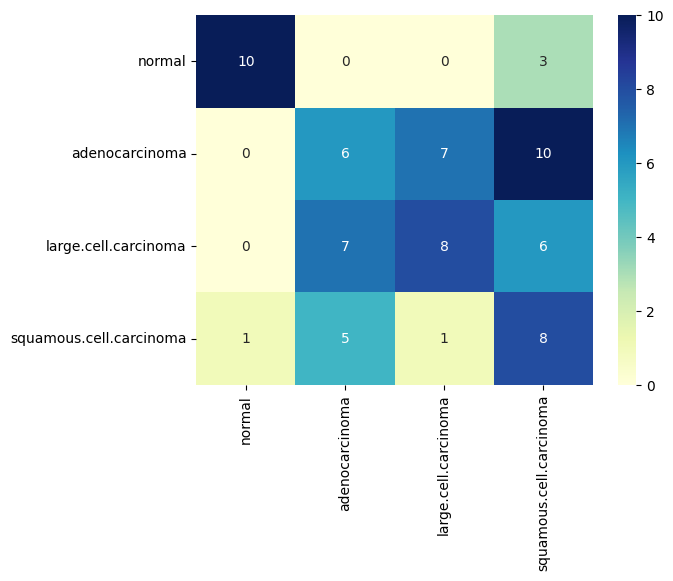

In [8]:
clf = DecisionTreeClassifier()

X_train = np.array([img.flatten() for img in train_sobel_edges])
X_val = np.array([img.flatten() for img in valid_sobel_edges])
sobel_preds = classify_decision_tree(X_train, train_labels, X_val, valid_labels)

plot_confusion_matrix(valid_labels, sobel_preds)

##### Hounsfield features

Accuracy: 0.4166666666666667


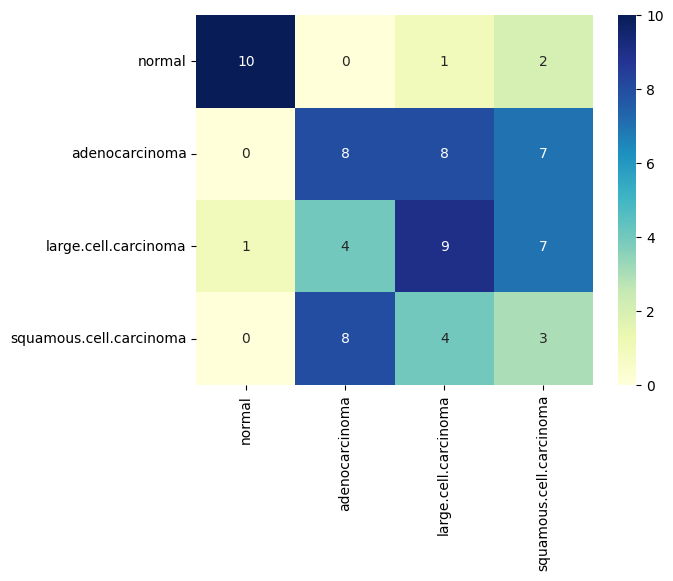

In [9]:
X_train = np.array([img.flatten() for img in train_hounsfield_edges])
X_val = np.array([img.flatten() for img in valid_hounsfield_edges])
hounsfield_preds = classify_decision_tree(X_train, train_labels, X_val, valid_labels)

plot_confusion_matrix(valid_labels, hounsfield_preds)

##### Simple threshold features

Accuracy: 0.4305555555555556


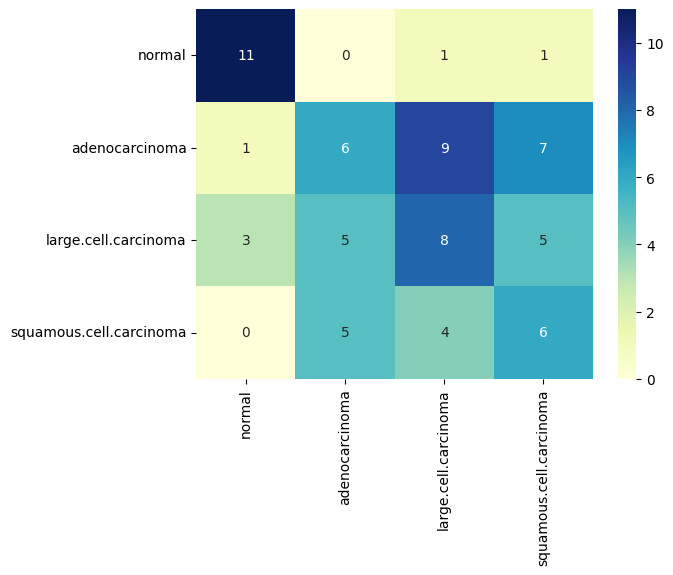

In [10]:
X_train = np.array([img.flatten() for img in train_threshold_edges])
X_val = np.array([img.flatten() for img in valid_threshold_edges])
thresh_preds = classify_decision_tree(X_train, train_labels, X_val, valid_labels)

plot_confusion_matrix(valid_labels, thresh_preds)

##### Canny edges

Accuracy: 0.4722222222222222


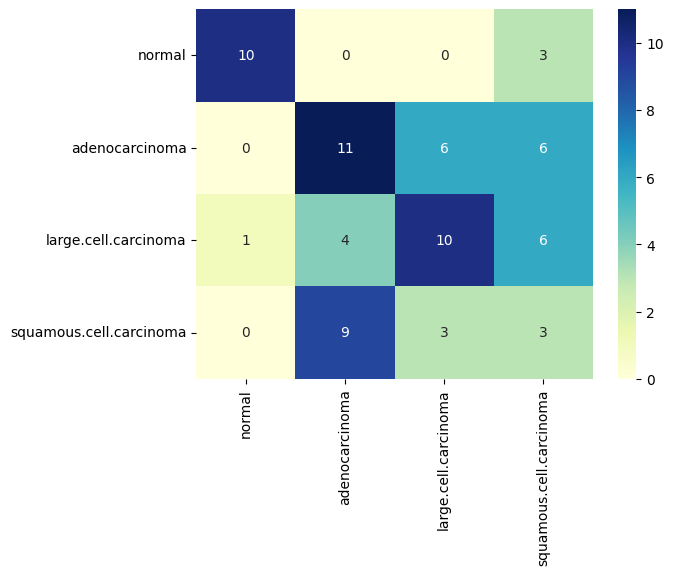

In [16]:
X_train = np.array([img.flatten() for img in train_canny_edges])
X_val = np.array([img.flatten() for img in valid_canny_edges])
thresh_preds = classify_decision_tree(X_train, train_labels, X_val, valid_labels)

plot_confusion_matrix(valid_labels, thresh_preds)

#### **Combined features**
This feature set yields better results than any of the individual edges alone

Accuracy: 0.4305555555555556


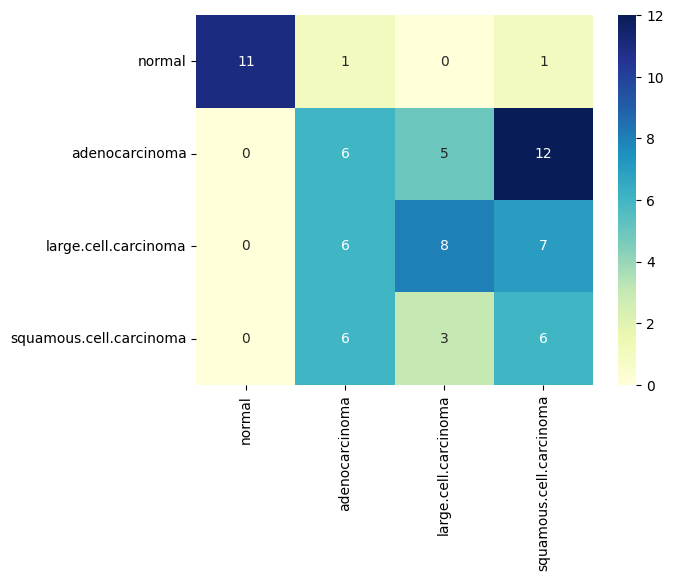

In [12]:
X_train = [np.array([w, x, y, z]).flatten() for w, x, y, z in zip(train_sobel_edges, train_hounsfield_edges, train_threshold_edges, train_canny_edges)]
X_val = [np.array([w, x, y, z]).flatten() for w, x, y, z in zip(valid_sobel_edges, valid_hounsfield_edges, valid_threshold_edges, valid_canny_edges)]
combined_preds = classify_decision_tree(X_train, train_labels, X_val, valid_labels)

plot_confusion_matrix(valid_labels, combined_preds)

Testing the PCA components

Accuracy: 0.3333333333333333


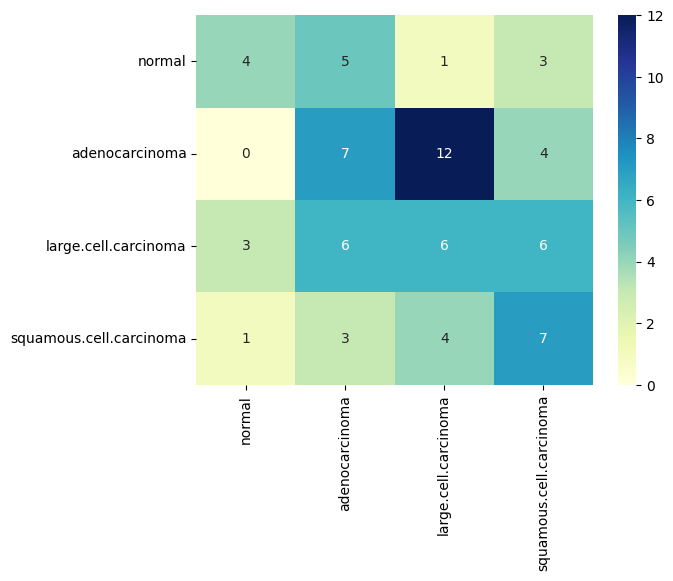

In [13]:
combined_preds = classify_decision_tree(X_train_combined_pca, train_labels, X_val_combined_pca, valid_labels)

plot_confusion_matrix(valid_labels, combined_preds)

Testing the TSNE components

Accuracy: 0.2777777777777778


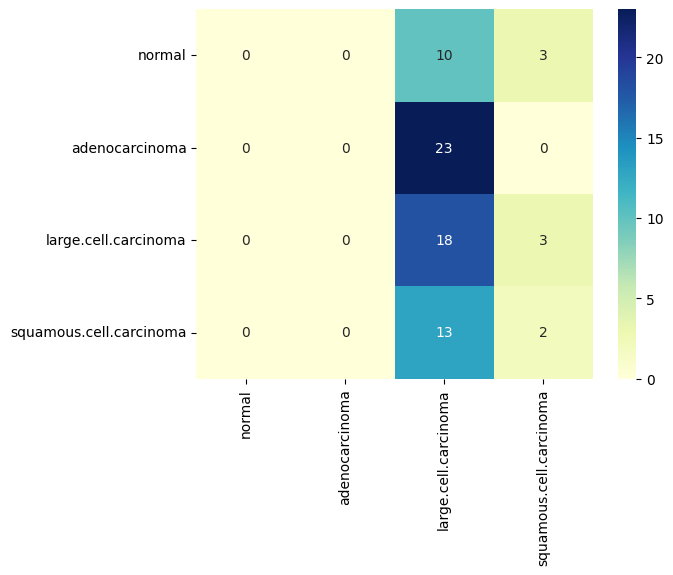

In [14]:
combined_preds = classify_decision_tree(X_train_combined_tsne, train_labels, X_val_combined_tsne, valid_labels)

plot_confusion_matrix(valid_labels, combined_preds)

## Grid Parameter search

In [17]:
# hyperparameter grid to search through
param_grid = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}

dt_classifier = DecisionTreeClassifier()

X_train = np.array([img.flatten() for img in train_canny_edges])
y_train = train_labels


In [18]:
# hyperparameter search on the training data
grid_search = GridSearchCV(dt_classifier, param_grid, scoring='accuracy', n_jobs=-1)

grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

In [19]:
X_val = np.array([img.flatten() for img in valid_canny_edges])
y_val = valid_labels

In [ ]:
y_pred = best_model.predict(X_val)
accuracy = accuracy_score(y_val, y_pred)
print("Best Model Accuracy:", accuracy)

In [ ]:
best_params